In [2]:
import os
import torch
import random
import numpy as np
import pytorch_lightning as pl
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
torch.set_default_dtype(torch.float)
from utils.ClassicDistributedKalman import diffusion_extended_kalman_filter_parallel_edge
from utils.DistributedKalmanData import (HSystem, HSystemLinear, FSystem, FSystemLinear, GraphDataset, CreateGraph)
from utils.DistributedKalmanNet import GraphKalmanProcess, StateKnowledge
from utils.BaselineModels import GnnRnnLightning

In [7]:
class NanInfChecker(pl.Callback):
    def on_after_backward(self, trainer, pl_module):
        for name, param in pl_module.named_parameters():
            if param.grad is not None and not torch.isfinite(param.grad).all():
                raise RuntimeError(f"NaN/Inf in gradient of {name}")
        if hasattr(trainer, 'batch'):
            feats, _, _, _ = trainer.batch
            if not torch.isfinite(feats).all():
                raise RuntimeError("Non-finite values in input batch")
            
class SkipNaNBatch(pl.Callback):
    def on_after_backward(self, trainer, pl_module):
        if any(torch.isnan(param.grad).any() for param in pl_module.parameters()):
            trainer.should_stop = False
            trainer.accumulated_batches = 0
            # trainer.fit_loop.epoch_loop.batch_loop.loop_running = False
            pl_module.zero_grad()

In [8]:
def seed_everything(seed=42):
    """
    Set the random seed for reproducibility.
    :param seed: the random seed to set
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [9]:
def run_experiment_classical_diffusion_kalman(dataset, f_sys, h_sys, r_array, q, P0, x0, time_steps, node_num):
    real_x_list = []
    predicted_x_list = []
    for graph_i in tqdm(dataset):
        real_x = graph_i.y[..., 0].numpy().T
        real_x_list.append(real_x)
        y_meas = graph_i.x.numpy().transpose(0, 2, 1)
        adj_matrix_graph = graph_i.adj_matrix.numpy()
        predicted_x = diffusion_extended_kalman_filter_parallel_edge(
            y_meas, f_sys, h_sys, r_array, q, P0, x0, adj_matrix_graph, time_steps=time_steps, node_num=node_num)
        # x_hat_local_kalman_list.append(x_hat_local_kalman)
        predicted_x_list.append(predicted_x)
    real_x_all = np.stack(real_x_list, axis=0)
    predicted_x_all = np.stack(predicted_x_list, axis=0)
    return real_x_all, predicted_x_all

def mean_distance_function(real_x, predicted_x):
    """
    Calculate the mean distance between the estimated points and the true points.
    :param real_x: true points
    :param predicted_x: estimated points
    :return: mean distance
    """
    return np.linalg.norm(predicted_x - real_x.transpose(0, 2, 1)[:, :, None, ..., None], 
                          axis=(-1, -2)).mean(axis=(0, 2))

def consensus_distance_function(predicted_x):
    """
    Calculate the consensus distance between the estimated points.
    :param predicted_x: estimated points
    :return: consensus distance
    """
    return np.linalg.norm(predicted_x - predicted_x.mean(axis=1, keepdims=True), axis=(-1, -2)).mean(axis=(0, 2))

In [10]:
f_sys_linear = FSystemLinear()
h_sys_linear = HSystemLinear(node_num=50)
mismatch_angle = np.deg2rad(20)
f_sys_linear_true = FSystemLinear(deg=mismatch_angle)

 # Deep Extended Kalman Filter

In [89]:
seed_everything(42)
NODE_NUM = 50
TIME_STEPS = 20
R_SCALE = 1
scale = 1
q = 1
P0 = 1 * np.eye(2)
x0 = scale * np.array([[1, 1], ]).T
r_array = R_SCALE * np.ones(NODE_NUM)

h_sys = HSystem(node_num=NODE_NUM)
f_sys = FSystem()
mismatch_angle = np.deg2rad(20)
f_sys_true = FSystem(deg=mismatch_angle)
g = CreateGraph(NODE_NUM, 5)

train_dataset = GraphDataset(g, f_sys_true, h_sys, q, r_array, monte_carlo_simulations=10000, time_steps=TIME_STEPS, n_expansions=1, x0=scale)  
val_dataset = GraphDataset(g , f_sys_true, h_sys, q, r_array, monte_carlo_simulations=256, time_steps=TIME_STEPS, n_expansions=1, x0=scale)
train_dataset_linear = GraphDataset(g, f_sys_linear_true, h_sys_linear, q, r_array, monte_carlo_simulations=10000, time_steps=TIME_STEPS, n_expansions=1, x0=scale)
val_dataset_linear = GraphDataset(g , f_sys_linear_true, h_sys_linear, q, r_array, monte_carlo_simulations=256, time_steps=TIME_STEPS, n_expansions=1, x0=scale)
# train_dataset_overfit
# train_dataset_overfit2 = [train_dataset[1] for _ in range(10000)]

In [19]:
#  torch.save(train_dataset.data, 'C:/Users/Lenovo/Documents/second_degree/thesis/distributedKNET/data/train_data_50_n_10_t.pt')

In [90]:
seed_everything(42)
BATCH_SIZE = 64
train_dataset_overfit_batch = [[train_dataset[i] for i in range(BATCH_SIZE)] for _ in range(100)]

train_dataset_overfit = [example for nested in train_dataset_overfit_batch for example in nested]
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
train_loader_overfit = DataLoader(train_dataset_overfit, shuffle=False, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [ ]:
# state_model_linear = StateKnowledge(f_sys_linear, signal_dim=2, q=q, r_array=r_array, x0=x0)

In [13]:
seed_everything(42)
kalman_process = GraphKalmanProcess(
    f_sys_linear, signal_dim=2, edge_features_dim=1, node_kalman_dim=4,  edge_kalman_dim=2, hidden_dim=64, lr=5e-5, r_array=R_SCALE, learn_edge_kalman=False, x0_scale=scale)
kalman_process = kalman_process.to(torch.float)

In [14]:
# create pl trainer
for name, param in kalman_process.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

gkf.gat_rnn.fc_delta_y_innov.0.weight torch.Size([64, 3])
gkf.gat_rnn.fc_delta_y_innov.0.bias torch.Size([64])
gkf.gat_rnn.fc_delta_y_innov.2.weight torch.Size([64, 64])
gkf.gat_rnn.fc_delta_y_innov.2.bias torch.Size([64])
gkf.gat_rnn.fc_r.0.weight torch.Size([64, 1])
gkf.gat_rnn.fc_r.0.bias torch.Size([64])
gkf.gat_rnn.fc_r.2.weight torch.Size([64, 64])
gkf.gat_rnn.fc_r.2.bias torch.Size([64])
gkf.gat_rnn.r_input_gru.weight_ih_l0 torch.Size([192, 64])
gkf.gat_rnn.r_input_gru.weight_hh_l0 torch.Size([192, 64])
gkf.gat_rnn.r_input_gru.bias_ih_l0 torch.Size([192])
gkf.gat_rnn.r_input_gru.bias_hh_l0 torch.Size([192])
gkf.gat_rnn.gcn_nodes.bias torch.Size([64])
gkf.gat_rnn.gcn_nodes.lin.weight torch.Size([64, 128])
gkf.gat_rnn.fc_signal_features.0.weight torch.Size([64, 4])
gkf.gat_rnn.fc_signal_features.0.bias torch.Size([64])
gkf.gat_rnn.fc_signal_features.2.weight torch.Size([64, 64])
gkf.gat_rnn.fc_signal_features.2.bias torch.Size([64])
gkf.gat_rnn.sigma_gru.weight_ih_l0 torch.Size([1

In [13]:
seed_everything(42)
# define early stopping for validation loss
early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss:_epoch', patience=5, verbose=True, mode='min', min_delta=0.01)
trainer = pl.Trainer(max_epochs=10, accelerator='auto', log_every_n_steps=5, callbacks=[early_stopping], gradient_clip_val=1)
# trainer = pl.Trainer(max_epochs=2000, accelerator='auto', log_every_n_steps=1)
trainer.fit(kalman_process, train_loader, val_loader)

In [515]:
kalman_process.state_dict()

OrderedDict([('gkf.gat_rnn.fc_delta_y_innov.0.weight',
              tensor([[ 4.3255e-01,  4.5574e-01, -1.4957e-01],
                      [ 5.3402e-01, -1.3491e-01,  1.7320e-01],
                      [-2.8132e-01,  3.3656e-01,  5.0200e-01],
                      [-4.2716e-01,  5.2340e-01,  1.6581e-01],
                      [ 4.2403e-01,  6.8468e-02,  2.7771e-01],
                      [-7.1411e-02,  4.5231e-01,  1.2751e-01],
                      [-2.7527e-01,  1.6248e-01, -2.7291e-01],
                      [-3.4880e-02, -2.6428e-01,  4.3810e-01],
                      [-4.5388e-01, -2.9166e-01, -1.3562e-01],
                      [-3.5195e-01,  8.5085e-02, -6.0484e-01],
                      [ 5.2663e-01, -5.1145e-01,  4.6538e-01],
                      [ 8.5977e-02, -2.0965e-01,  3.6485e-01],
                      [ 8.5591e-02,  4.9526e-01,  5.8999e-02],
                      [-1.7789e-01,  1.8743e-01, -1.9021e-01],
                      [ 2.4513e-01,  5.4505e-01,  4.0436e-01],


In [662]:
# torch.save(kalman_process.state_dict(), 'C:/Users/Lenovo/Documents/second_degree/thesis/distributedKNET/models/with_mismatch/kalman_process_50n_local_params_r_quarter_20deg.pth')

In [15]:
kalman_process.load_state_dict(
    torch.load('C:/Users/Lenovo/Documents/second_degree/thesis/distributedKNET/models/no_mismatch/kalman_process_50n_local_params_linear.pth'))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13012\1043176209.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('C:/Users/Lenovo/Documents/second_degree/thesis/

<All keys matched successfully>

In [17]:
# NODE_NUM = 50
node_num_test = 50
test_time_steps = 100
h_sys_test = HSystem(node_num=node_num_test)
# mismatch of 15 degrees in radians
mismatch_angle = np.deg2rad(20)
print(mismatch_angle)
f_sys_test = FSystem(alpha=1.0, beta=1.0, sigma=0.0, delta=0.0, deg=mismatch_angle)
g_test = CreateGraph(node_num_test, 5)
test_dataset_time = GraphDataset(g_test, f_sys_test, h_sys_test, q, r_array=0.1*np.ones(node_num_test), monte_carlo_simulations=100, time_steps=test_time_steps, n_expansions=1)

0.3490658503988659


In [10]:
# torch.save(kalman_process.state_dict(), 'C:/Users/Lenovo/Documents/second_degree/thesis/distributedKNET/models/kalman_process_50n_params.pt')

In [47]:
gnn_rnn = GnnRnnLightning(input_dim=1, type_num=2, hidden_dim=32, output_dim=2, lr=1e-4)
gnn_rnn.load_state_dict(torch.load(
    'C:/Users/Lenovo/Documents/second_degree/thesis/distributedKNET/models/gnn-rnn/gnn_rnn_r_quarter_linear.pth'))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13012\1546798389.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gnn_rnn.load_state_dict(torch.load(


<All keys matched successfully>

In [94]:
noise_levels = R_SCALE * np.linspace(1, 1, 1)
mean_dist_classical_kalman = []
all_err_classical_kalman = []
mean_dist_deep_kalman = []
all_err_deep_kalman = []
# kalman_process.eval()
for noise in tqdm(noise_levels):
    test_noise_dataset = GraphDataset(g_test, f_sys_true , h_sys, q, noise * np.ones(node_num_test), monte_carlo_simulations=100, time_steps=test_time_steps, n_expansions=1, x0=scale)
    x_real, x_pred_classical = run_experiment_classical_diffusion_kalman(
        test_noise_dataset, f_sys_true , h_sys, noise * np.ones(node_num_test), q, P0, x0, time_steps=test_time_steps, node_num=node_num_test)
    # classical_errors = mean_distance_function(x_real, x_pred_classical)
    # all_err_classical_kalman.append(classical_errors)
    # mean_dist_classical_kalman.append(np.mean(classical_errors))
    # print(noise, np.mean(mean_distance_function(x_real, x_pred_classical)))
    # x_pred_deep_list = []
    # with torch.no_grad():
    #     for graph in tqdm(test_noise_dataset):
    #         # x_real = test_noise_dataset.y[..., 0]
    #         x_pred_deep = kalman_process(graph)
    #         x_pred_deep_mean = x_pred_deep.mean(axis=(0, 2, -1)).numpy()
    #         x_pred_deep_list.append(x_pred_deep_mean)
    # x_pred_deep_all = np.stack(x_pred_deep_list, axis=0)
    # deep_errors = np.linalg.norm(x_pred_deep_all - x_real.transpose(0, 2, 1), axis=-1).mean(0)
    # all_err_deep_kalman.append(deep_errors)
    # mean_dist_deep_kalman.append(deep_errors.mean())
    
    if True:
        x_pred_gnn_list = []
        with torch.no_grad():
            for graph in tqdm(test_noise_dataset):
                x_pred_gnn_rnn = gnn_rnn(
                    graph.x, graph.h_system.node_classification.int(), graph.edge_index, None)
                x_pred_gnn_rnn_mean = x_pred_gnn_rnn.mean(axis=0).numpy()
                x_pred_gnn_list.append(x_pred_gnn_rnn_mean)
        x_pred_gnn_all = np.stack(x_pred_gnn_list, axis=0)
        gnn_errors = np.linalg.norm(x_pred_gnn_all - x_real.transpose(0, 2, 1), axis=-1).mean(0)
        
all_err_deep_kalman = np.stack(all_err_deep_kalman, axis=0)
all_err_classical_kalman = np.stack(all_err_classical_kalman, axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: need at least one array to stack

In [95]:
10 * np.log10(gnn_errors.mean())

np.float32(2.9004993)

In [60]:
10 * torch.log10(torch.cdist(x_pred_gnn_rnn.transpose(1, 0), x_pred_gnn_rnn.transpose(1, 0)).mean())

tensor(1.3759)

1.0


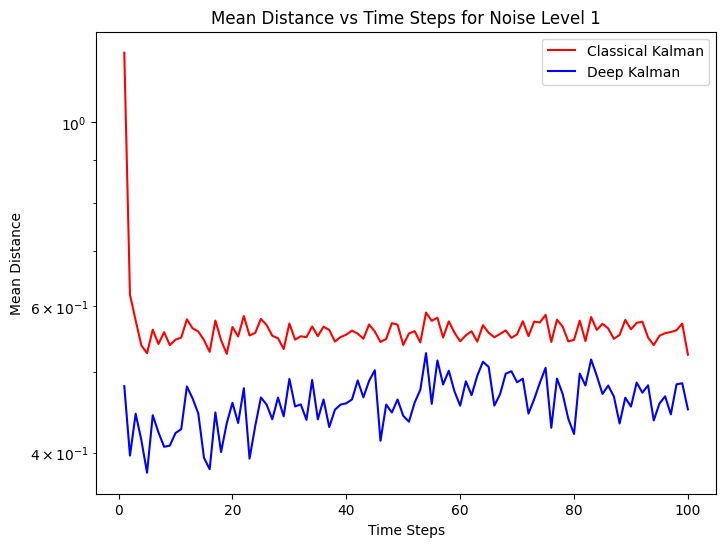

In [73]:
# for the first noise, plot time steps vs mean distance for classical and deep kalman
noise_level = 0
time_step_cut = 100
plt.figure(figsize=(8, 6))
plt.plot(
    np.arange(1, time_step_cut+1), all_err_classical_kalman[noise_level][:time_step_cut], 'r', label='Classical Kalman')
plt.plot(np.arange(1, time_step_cut+1), all_err_deep_kalman[noise_level][:time_step_cut], 'b', label='Deep Kalman')
plt.legend()
plt.xlabel('Time Steps')
plt.yscale('log')
plt.ylabel('Mean Distance')
plt.title('Mean Distance vs Time Steps for Noise Level 1')
print(noise_levels[noise_level])

In [123]:
mean_err_classical = all_err_classical_kalman[:,:].mean()
mean_err_deep = all_err_deep_kalman[:, :90].mean()
# calculate in db
mean_err_classical_db = 10 * np.log10(mean_err_classical)
mean_err_deep_db = 10 * np.log10(mean_err_deep)
print(mean_err_classical_db, mean_err_deep_db)
# mean_err_classical_db

0.3804934280248886 -1.9719024


In [684]:
mean_err_classical = all_err_classical_kalman.mean()
mean_err_classical_db = 10 * np.log10(mean_err_classical)
mean_err_classical_db

np.float64(1.812032524302272)

Text(0.5, 0.98, 'Mean Distance vs Noise Level')

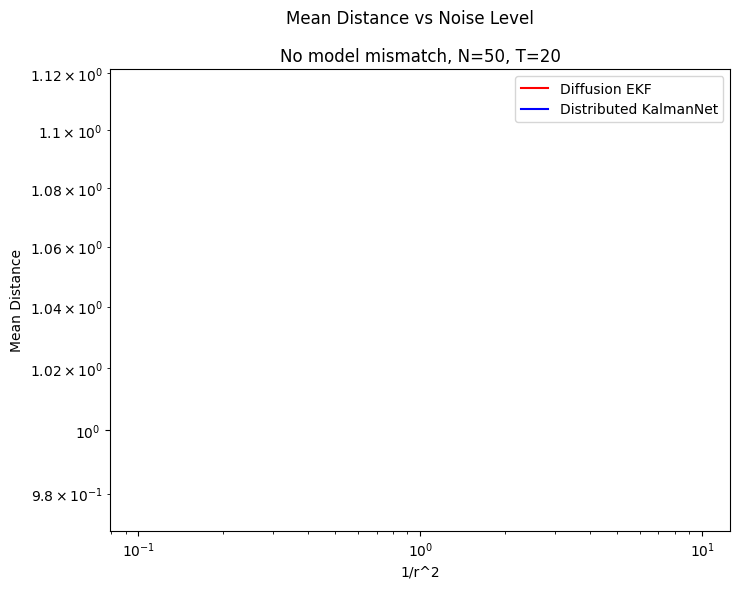

In [486]:
# make plot of mean distance vs noise level both for classical and deep kalman
plt.figure(figsize=(8, 6))
plt.plot(1/(noise_levels**2), mean_dist_classical_kalman, 'r', label='Diffusion EKF')
plt.plot(1/(noise_levels**2), mean_dist_deep_kalman, 'b', label='Distributed KalmanNet')
plt.legend()
plt.xlabel('1/r^2')
plt.xscale('log')
# plot y in log scale
plt.yscale('log')
plt.ylabel('Mean Distance') 
plt.title('No model mismatch, N=50, T=20')
# subtitle
plt.suptitle('Mean Distance vs Noise Level')


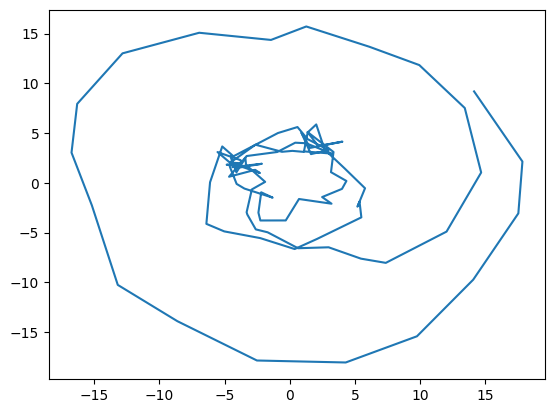

In [648]:
trajectory_num = 4
plt.plot(test_noise_dataset[trajectory_num].y[:, 0, 0].numpy(), 
         test_noise_dataset[trajectory_num].y[:, 1, 0].numpy(), label='True')

In [96]:
err_db = 10 * np.log10(1/ np.array([0.25, 0.5, 1, 2, 4])**2)
no_mismatch_classic_err_db = [-7.29, -5.548, -3.097, -0.754, 1.276]
no_mismatch_deep_err_db = [-6.924, -5.332, -3.817, -1.33, 0.216]
mismatch_classic_err_db = [-2.147, -1.366, 0.469, 3.411, 6.66]
mismatch_deep_err_db = [-3.439, -2.655, -1.754, 0.632, 3.594]
gnn_rnn_err_db = [2.9, 3.23, 3.501, 4.00, 4.917]

In [68]:
linear_no_mismatch_classic_err_db = [-4.922, -3.496, -1.631, 0.258, 1.987]
linear_no_mismatch_deep_err_db = [-4.4, -2.926, -2.22, -0.45, 1.339]
linear_mismatch_classic_err_db = [-0.473, 0.458, 2.362, 4.826, 6.771]
linear_mismatch_deep_err_db = [-3.413, -2.668, -1.707, 0.543, 2.199]
linear_gnn_rnn_err_db = [3.807, 3.819, 3.95, 4.645, 5.623]

In [321]:
20 * np.log10(1.12)

np.float64(0.9843604534036331)

In [364]:
10 * np.log10(0.85)

np.float64(-0.7058107428570728)

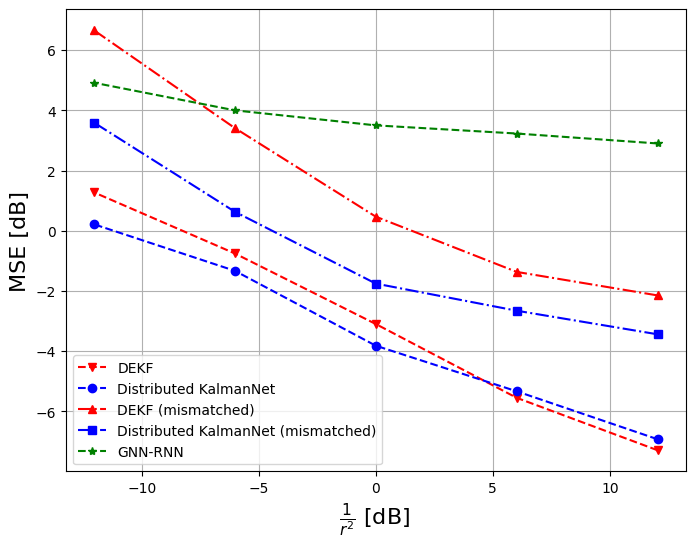

In [97]:
# plot both for no mismatch vs err_db
plt.figure(figsize=(8, 6))
plt.plot(err_db, no_mismatch_classic_err_db, 'rv--', label='DEKF')
plt.plot(err_db, no_mismatch_deep_err_db, 'bo--', label='Distributed KalmanNet')
plt.plot(err_db, mismatch_classic_err_db, 'r^-.', label=r'DEKF (mismatched)')  
# write degrees above the 20 
plt.plot(err_db, mismatch_deep_err_db, 'bs-.', label=r"Distributed KalmanNet (mismatched)")
plt.plot(err_db, gnn_rnn_err_db, 'g*--', label='GNN-RNN')
# plt.plot(err_db, mismatch_deep_err_db, 'b*-.', label='Distributed KalmanNet rotated 20')
plt.legend()
plt.grid(True)
plt.xlabel(r'$\frac{1}{r^2}$ [dB] ', fontsize=16)
plt.ylabel('MSE [dB]', fontsize=16)
# plt.title('No Model Mismatch')
# save figure as png
plt.savefig('C:/Users/Lenovo/Documents/second_degree/thesis/distributedKNET/figures/nonlinear_50n_20t.png', dpi=300)

Text(0.5, 1.0, 'Model Mismatch of 20 degrees')

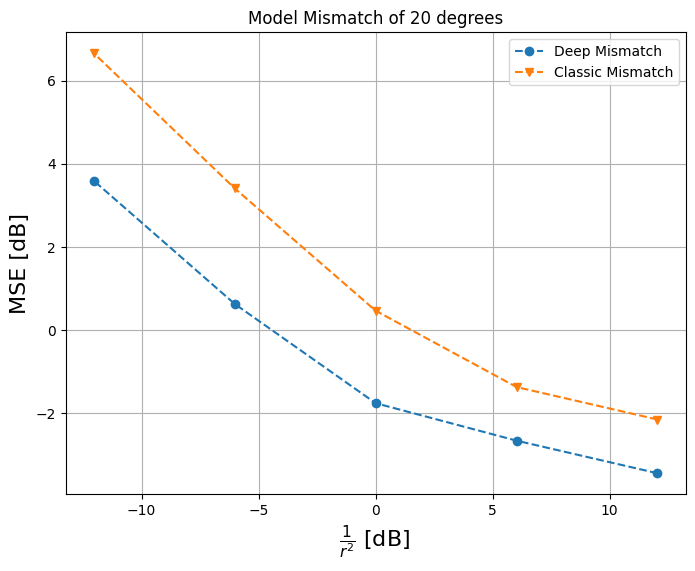

In [649]:
# plot both for mismatch vs err_db, add points
plt.figure(figsize=(8, 6))
plt.plot(err_db, mismatch_deep_err_db, 'o--', label='Deep Mismatch')
plt.plot(err_db, mismatch_classic_err_db, 'v--', label='Classic Mismatch')
plt.legend()
plt.grid(True)
plt.xlabel(r'$\frac{1}{r^2}$ [dB] ', fontsize=16)
plt.ylabel('MSE [dB]', fontsize=16)
plt.title('Model Mismatch of 20 degrees')

Text(0.5, 1.0, 'No Model Mismatch, linear')

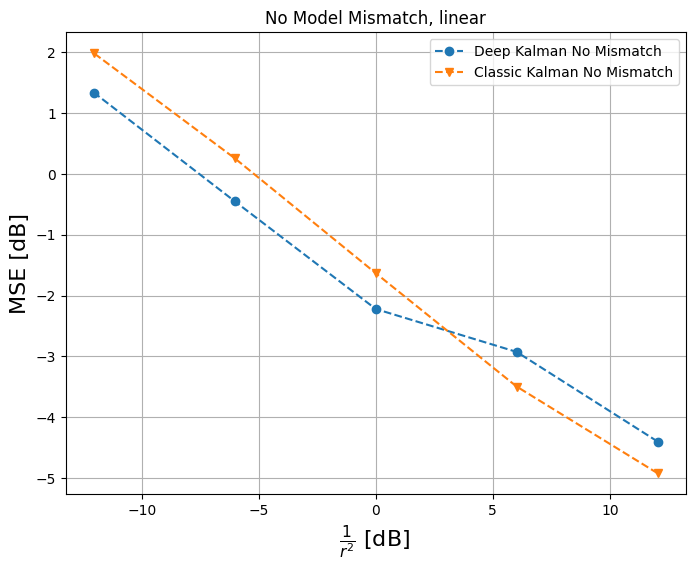

In [651]:
plt.figure(figsize=(8, 6))
plt.plot(err_db, linear_no_mismatch_deep_err_db, 'o--', label='Deep Kalman No Mismatch')
plt.plot(err_db, linear_no_mismatch_classic_err_db, 'v--', label='Classic Kalman No Mismatch')
plt.legend()
plt.grid(True)
plt.xlabel(r'$\frac{1}{r^2}$ [dB] ', fontsize=16)
plt.ylabel('MSE [dB]', fontsize=16)
plt.title('No Model Mismatch, linear')

Text(0.5, 1.0, 'Model Mismatch of 20 degrees, linear')

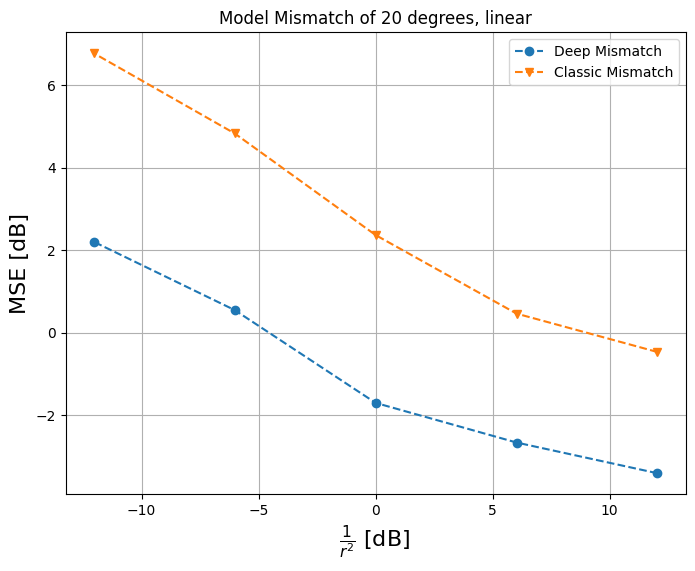

In [650]:
# plot both for mismatch vs err_db, add points
plt.figure(figsize=(8, 6))
plt.plot(err_db, linear_mismatch_deep_err_db, 'o--', label='Deep Mismatch')
plt.plot(err_db, linear_mismatch_classic_err_db, 'v--', label='Classic Mismatch')
plt.legend()
plt.grid(True)
plt.xlabel(r'$\frac{1}{r^2}$ [dB] ', fontsize=16)
plt.ylabel('MSE [dB]', fontsize=16)
plt.title('Model Mismatch of 20 degrees, linear')

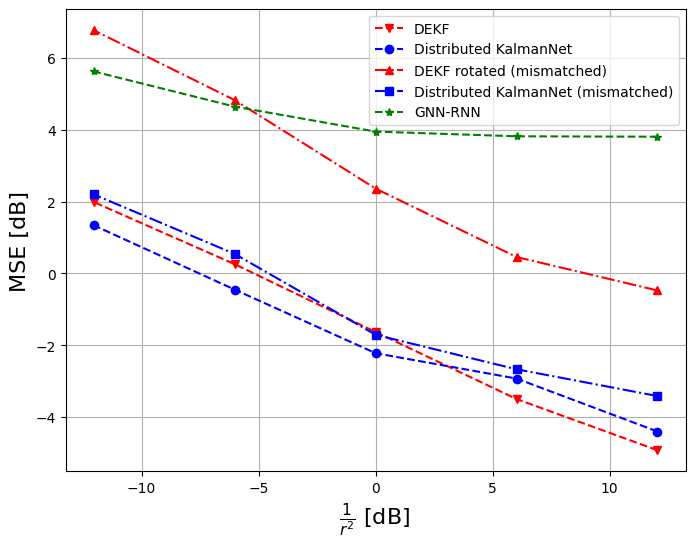

In [72]:
# same as in the nonlinear saved plot 
plt.figure(figsize=(8, 6))
plt.plot(err_db, linear_no_mismatch_classic_err_db, 'rv--', label='DEKF')
plt.plot(err_db, linear_no_mismatch_deep_err_db, 'bo--', label='Distributed KalmanNet')
plt.plot(err_db, linear_mismatch_classic_err_db, 'r^-.', label=r'DEKF rotated (mismatched)')
# write degrees above the 20
plt.plot(err_db, linear_mismatch_deep_err_db, 'bs-.', label=r"Distributed KalmanNet (mismatched)")
plt.plot(err_db, linear_gnn_rnn_err_db, 'g*--', label='GNN-RNN')
plt.legend()
plt.grid(True)
plt.xlabel(r'$\frac{1}{r^2}$ [dB] ', fontsize=16)
plt.ylabel('MSE [dB]', fontsize=16)
# plt.title('No Model Mismatch')
# save figure as png
plt.savefig('C:/Users/Lenovo/Documents/second_degree/thesis/distributedKNET/figures/linear_50n_20t.png', dpi=300)

In [177]:
x_pred_classical.shape

(20, 100, 50, 2, 1)

In [74]:
classical_consensus_dist = torch.cdist(torch.tensor(x_pred_classical[..., 0]), torch.tensor(x_pred_classical[..., 0])).mean(dim=(0, -1, -2))

In [75]:
deep_consensus_dist = torch.cdist(torch.tensor(x_pred_deep[..., 0]), torch.tensor(x_pred_deep[..., 0])).mean(dim=(0, -1, -2))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_944\1344027391.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deep_consensus_dist = torch.cdist(torch.tensor(x_pred_deep[..., 0]), torch.tensor(x_pred_deep[..., 0])).mean(dim=(0, -1, -2))


Text(0.5, 1.0, 'Consensus Distance vs Time Steps for Noise Level 1')

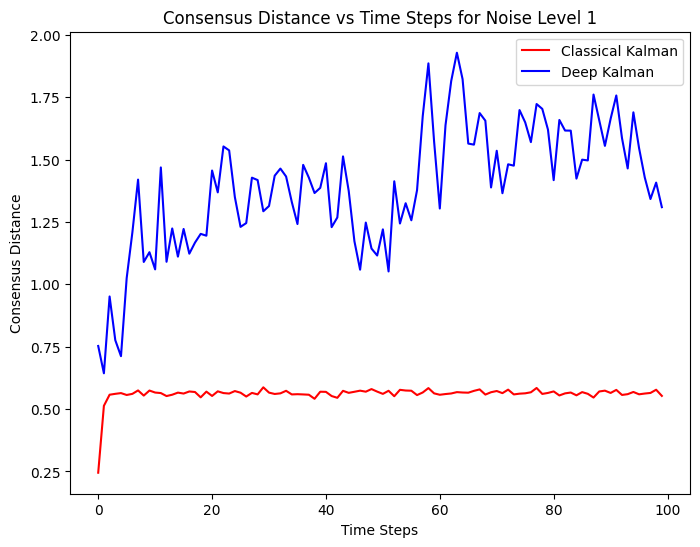

In [76]:
# plot those two sizes
plt.figure(figsize=(8, 6))
plt.plot(classical_consensus_dist.numpy(), 'r', label='Classical Kalman')
plt.plot(deep_consensus_dist.numpy(), 'b', label='Deep Kalman')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Consensus Distance')
plt.title('Consensus Distance vs Time Steps for Noise Level 1')

In [77]:
print(10*torch.log10(deep_consensus_dist.mean()), 10*torch.log10(classical_consensus_dist.mean())) 

tensor(1.4306) tensor(-2.5102, dtype=torch.float64)


In [135]:
torch.cdist(torch.tensor(x_pred_deep[0,..., 0]), torch.tensor(x_pred_deep[0,..., 0])).mean((0, 2)).mean()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27224\4182275635.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.cdist(torch.tensor(x_pred_deep[0,..., 0]), torch.tensor(x_pred_deep[0,..., 0])).mean((0, 2)).mean()


tensor(1.1225)

# Try naive gnn-rnn approach

In [54]:
torch.set_default_dtype(torch.float)
gnn_rnn = GnnRnnLightning(input_dim=1, type_num=2, hidden_dim=32, output_dim=2, lr=1e-4)

In [ ]:
early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss:_epoch', patience=5, verbose=True, mode='min', min_delta=0.01)
trainer = pl.Trainer(max_epochs=25, accelerator='auto', log_every_n_steps=5, callbacks=[early_stopping])
# trainer = pl.Trainer(max_epochs=2000, accelerator='auto', log_every_n_steps=100)
trainer.fit(gnn_rnn, train_loader, val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | fc_measurement | Sequential | 1.1 K  | train
1 | type_embedding | Embedding  | 64     | train
2 | gcn1           | GCNConv    | 4.2 K  | train
3 | activation     | LeakyReLU  | 0      | train
4 | gcn2           | GCNConv    | 4.2 K  | train
5 | gru            | GRU        | 25.0 K | train
6 | fc_output      | Sequential | 2.1 K  | train
7 | loss           | MSELoss    | 0      | train
------------------------------------------------------
36.6 K    Trainable params
0         Non-trainable params
36.6 K    Total params
0.146     Total estimated model params size (MB)
19

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved. New best score: 7.741


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.766 >= min_delta = 0.01. New best score: 6.974


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.361 >= min_delta = 0.01. New best score: 6.613


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.216 >= min_delta = 0.01. New best score: 6.398


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.119 >= min_delta = 0.01. New best score: 6.278


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.061 >= min_delta = 0.01. New best score: 6.218


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.059 >= min_delta = 0.01. New best score: 6.159


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.112 >= min_delta = 0.01. New best score: 6.048


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.063 >= min_delta = 0.01. New best score: 5.984


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.039 >= min_delta = 0.01. New best score: 5.945


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.077 >= min_delta = 0.01. New best score: 5.868


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.047 >= min_delta = 0.01. New best score: 5.822


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.051 >= min_delta = 0.01. New best score: 5.770


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.050 >= min_delta = 0.01. New best score: 5.720


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.037 >= min_delta = 0.01. New best score: 5.683


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.017 >= min_delta = 0.01. New best score: 5.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.040 >= min_delta = 0.01. New best score: 5.627


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.011 >= min_delta = 0.01. New best score: 5.615


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.044 >= min_delta = 0.01. New best score: 5.572


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss:_epoch improved by 0.013 >= min_delta = 0.01. New best score: 5.532
`Trainer.fit` stopped: `max_epochs=25` reached.


In [169]:
gnn_rnn(train_dataset_overfit[0].x, train_dataset_overfit[0].h_system.node_classification.int(), train_dataset_overfit[0].edge_index, None)

tensor([[[  1.9833,   3.8033],
         [  1.6402,   3.4779],
         [  2.2035,   3.3330],
         ...,
         [ -7.2819,  -8.8159],
         [ -4.5688, -12.2281],
         [ -1.3277, -13.4081]],

        [[  2.0420,   3.5702],
         [  1.8775,   3.4933],
         [  1.9938,   3.3910],
         ...,
         [ -7.4246,  -8.5449],
         [ -4.8069, -12.3517],
         [ -1.2873, -13.8174]],

        [[  1.7837,   3.9275],
         [  1.1998,   4.1262],
         [  1.2390,   3.7567],
         ...,
         [ -6.4414,  -7.6314],
         [ -4.3519, -10.3160],
         [ -3.5501, -11.1892]],

        ...,

        [[  1.9668,   2.7180],
         [  1.8650,   3.3125],
         [  1.5846,   3.3081],
         ...,
         [ -6.9296,  -9.2289],
         [ -4.1519, -12.8399],
         [ -2.0598, -14.0778]],

        [[  2.1012,   2.8818],
         [  1.9249,   3.3851],
         [  1.6218,   3.3187],
         ...,
         [ -6.3675,  -9.7481],
         [ -3.2141, -13.0022],
         

In [ ]:
train_dataset_overfit[0].y

In [93]:
1+1

2

In [86]:
# save model
torch.save(gnn_rnn.state_dict(), 'C:/Users/Lenovo/Documents/second_degree/thesis/distributedKNET/models/gnn-rnn/gnn_rnn_r_half.pth')

In [91]:
# load model
gnn_rnn.load_state_dict(torch.load('C:/Users/Lenovo/Documents/second_degree/thesis/distributedKNET/models/gnn-rnn/gnn_rnn_r_quarter.pth'))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13012\479332631.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gnn_rnn.load_state_dict(torch.load('C:/Users/Lenovo/Document

<All keys matched successfully>

In [772]:
for batch in train_loader:
    print(batch.x.shape)
    print(batch.h_system[0].node_classification.repeat_interleave(batch.num_graphs, dim=0).shape)
    print(batch[0])
    break

torch.Size([3200, 20, 1])
torch.Size([3200, 1])


AttributeError: 'GlobalStorage' object has no attribute 'graph'

In [713]:
batch.num_graphs

64